In [1]:
# ─── Celda 1: configuración de paths e imports ─────────────────────────────────

import os, sys
import pandas as pd

# Añadir la carpeta raíz (proyecto_pv/) al path para poder importar src/
root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if root not in sys.path:
    sys.path.insert(0, root)

# Ahora podemos importar nuestros módulos
from src.config          import PVGISParams
from src.timezone_utils  import get_utc_offset_hours
from src.pvgis_client    import fetch_pvgis_hourly
from src.processing      import compute_annual_median, align_consumption, compute_pv_metrics
from src.reporting       import monthly_report, plot_monthly
from src.reporting       import plot_hourly_comparison



print("✅ Entorno listo, imports OK")

from dotenv import load_dotenv
load_dotenv("../.env")

✅ Entorno listo, imports OK


True

In [2]:
# ─── Celda 2: selector de lat/lon con ipyleaflet ────────────────────────────────

from ipyleaflet import Map, Marker
from IPython.display import display, clear_output

# Coordenadas iniciales (Madrid)
lat, lon = 40.4165, -3.7026

# Crear mapa y marcador inicial
m = Map(center=(lat, lon), zoom=5)
marker = Marker(location=(lat, lon))
m.add_layer(marker)

def handle_click(**event):
    global lat, lon, marker
    if event.get('type') == 'click':
        lat, lon = event['coordinates']
        # Actualizar marcador
        m.remove_layer(marker)
        marker = Marker(location=(lat, lon))
        m.add_layer(marker)
        # Volver a mostrar el mapa + coordenadas
        clear_output(wait=True)
        display(m)
        print(f"Coordenadas seleccionadas →  lat: {lat:.4f},  lon: {lon:.4f}")

m.on_interaction(handle_click)

print("🔹 Haz clic en el mapa para elegir la ubicación")
display(m)


Map(bottom=2126767.0, center=[-2.523893068240551, -79.91313457489015], controls=(ZoomControl(options=['positio…

In [3]:
# ─── Celda 3: timezone + consulta PVGIS ─────────────────────────────────────────

# 1) Calculamos el offset UTC (horas) para lat/lon
utc_offset = get_utc_offset_hours(lat, lon)
print(f"⏰ UTC offset: {utc_offset:+.1f} h")

# 2) Preparamos parámetros PVGIS (ajusta años, potencia, pérdidas, etc.)
params = PVGISParams(
    lat=lat,
    lon=lon,
    startyear=2013,
    endyear=2023,
    peakpower=1.0,
    loss=15.0
)

# 3) Llamada al API de PVGIS
df_pvgis, meta = fetch_pvgis_hourly(params)
print("📊 Metadata PVGIS:", meta)

# 4) Ajuste de zona horaria: convertimos el índice UTC a hora local
#    Movemos el índice UTC según el offset calculado
#    Creamos una nueva serie temporal 'time_local'
df_pvgis = df_pvgis.copy()
df_pvgis.index = df_pvgis.index + pd.to_timedelta(utc_offset, unit='h')
df_pvgis.index.name = 'time_local'

# 5) Mostrar las primeras filas con la hora local ajustada


⏰ UTC offset: -5.0 h
📊 Metadata PVGIS: {'inputs': {'location': {'description': 'Selected location', 'variables': {'latitude': {'description': 'Latitude', 'units': 'decimal degree'}, 'longitude': {'description': 'Longitude', 'units': 'decimal degree'}, 'elevation': {'description': 'Elevation', 'units': 'm'}}}, 'meteo_data': {'description': 'Sources of meteorological data', 'variables': {'radiation_db': {'description': 'Solar radiation database'}, 'meteo_db': {'description': 'Database used for meteorological variables other than solar radiation'}, 'year_min': {'description': 'First year of the calculations'}, 'year_max': {'description': 'Last year of the calculations'}, 'use_horizon': {'description': 'Include horizon shadows'}, 'horizon_db': {'description': 'Source of horizon data'}}}, 'mounting_system': {'description': 'Mounting system', 'choices': 'fixed, vertical_axis, inclined_axis, two_axis', 'fields': {'slope': {'description': 'Inclination angle from the horizontal plane', 'units':

In [4]:
display(df_pvgis.head(20))

,P,G(i),H_sun,T2m,WS10m,Int
time_local,,,,,,
2012-12-31 19:30:00+00:00,0.00,0.00,0.00,25.62,2.21,0.0
2012-12-31 20:30:00+00:00,0.00,0.00,0.00,25.50,2.28,0.0
2012-12-31 21:30:00+00:00,0.00,0.00,0.00,24.99,1.93,0.0
2012-12-31 22:30:00+00:00,0.00,0.00,0.00,24.70,1.86,0.0
2012-12-31 23:30:00+00:00,0.00,0.00,0.00,24.53,2.07,0.0
2013-01-01 00:30:00+00:00,0.00,0.00,0.00,24.18,2.28,0.0
2013-01-01 01:30:00+00:00,0.00,0.00,0.00,23.91,2.76,0.0
2013-01-01 02:30:00+00:00,0.00,0.00,0.00,23.83,2.90,0.0
2013-01-01 03:30:00+00:00,0.00,0.00,0.00,23.47,2.97,0.0


In [5]:
# ─── Celda 4: procesado de series ───────────────────────────────────────────────

# 4.1) Perfil anual mediano de irradiación o generación
profile = compute_annual_median(df_pvgis, 'P')
print("Perfil horario (primeros 5):")
print(profile.head(10))


Perfil horario (primeros 5):
mdh
01-01 00:30      0.00
01-01 01:30      0.00
01-01 02:30      0.00
01-01 03:30      0.00
01-01 04:30      0.00
01-01 05:30      0.00
01-01 06:30      1.53
01-01 07:30     71.66
01-01 08:30    178.42
01-01 09:30    310.17
Name: P, dtype: float64


In [6]:
# ─── Celda 5: carga de consumos con FileUpload ─────────────────────────────────

import io
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

upload = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='Subir CSV consumo'
)
display(upload)

def on_upload_change(change):
    # change['new'] es una tupla de diccionarios con metadatos y contenido
    if upload.value:
       # Tomamos el primer elemento de la tupla
        fileinfo = upload.value[0]
        fname = fileinfo.get('name')
        content = fileinfo.get('content')
        # Leemos en DataFrame usando BytesIO
        df_consum = pd.read_csv(
            io.BytesIO(content),
            parse_dates=['fecha_hora'],
            index_col='fecha_hora'
        )
        # Guardamos la variable en globals para usarla luego
        globals()['df_consum'] = df_consum
        print(f"📥 '{fname}' cargado. Shape: {df_consum.shape}")
        display(df_consum.head())

# Observamos cambios en el widget
upload.observe(on_upload_change, names='value')


FileUpload(value=(), accept='.csv', description='Subir CSV consumo')

,potencia_bombeo_kW,potencia_aeracion_kW,energia_bombeo_kWh,energia_aeracion_kWh,energia_total_kWh,potencia_total_kW
fecha_hora,,,,,,
2024-01-01 00:30:00,0.000000,1500.0,0.000000,750.0,750.000000,1500.000000
2024-01-01 01:30:00,0.000000,1500.0,0.000000,750.0,750.000000,1500.000000
2024-01-01 02:30:00,0.000000,1500.0,0.000000,750.0,750.000000,1500.000000
2024-01-01 03:30:00,1434.210526,1500.0,717.105263,750.0,1467.105263,2934.210526
2024-01-01 04:30:00,1434.210526,1500.0,1434.210526,750.0,2184.210526,2934.210526


In [7]:

# ─── Celda 6: procesado de consumos ─────────────────────────────────────────────

# 4.3) Alinear consumo (kWh) con perfil (W)
df_aligned = align_consumption(df_consum['energia_total_kWh'], profile)
df_aligned.head()


,energy_kWh,profile_W
fecha_hora,,
2024-01-01 00:30:00,750.000000,0.0
2024-01-01 01:30:00,750.000000,0.0
2024-01-01 02:30:00,750.000000,0.0
2024-01-01 03:30:00,1467.105263,0.0
2024-01-01 04:30:00,2184.210526,0.0


In [8]:
# ─── Celda 7: cálculo de métricas PV ───────────────────────────────────────────

df_metrics, installed_kw = compute_pv_metrics(df_aligned)
print(f"✔️ Potencia instalada sugerida (75 percentil): {installed_kw:.2f} kW")

# Ver primeras filas
df_metrics.head(24)


✔️ Potencia instalada sugerida (75 percentil): 6307.15 kW


,energy_kWh,profile_W,required_kW,pv_generated_kWh,pv_consumed_kWh,pv_surplus_kWh
fecha_hora,,,,,,
2024-01-01 00:30:00,750.000000,0.00,0.000000e+00,0.000000,0.000000,0.000000
2024-01-01 01:30:00,750.000000,0.00,0.000000e+00,0.000000,0.000000,0.000000
2024-01-01 02:30:00,750.000000,0.00,0.000000e+00,0.000000,0.000000,0.000000
2024-01-01 03:30:00,1467.105263,0.00,0.000000e+00,0.000000,0.000000,0.000000
2024-01-01 04:30:00,2184.210526,0.00,0.000000e+00,0.000000,0.000000,0.000000
2024-01-01 05:30:00,2184.210526,0.00,0.000000e+00,0.000000,0.000000,0.000000
2024-01-01 06:30:00,2184.210526,1.53,1.427589e+06,9.649934,9.649934,0.000000
2024-01-01 07:30:00,2184.210526,71.66,3.048019e+04,451.970092,451.970092,0.000000
2024-01-01 08:30:00,2184.210526,178.42,1.224196e+04,1125.321014,1125.321014,0.000000


,energía_total_demandada_kWh,profile_W,required_kW,energía_pv_generada_kWh,energía_pv_consumida_directamente_kWh,energía_pv_disponible_excedente_kWh,self_consumption_rate,self_sufficiency_rate,surplus_generation_rate
fecha_hora,,,,,,,,,
2024-01-31,1.296618e+06,92439.32,3.432559e+08,583028.300136,395872.243523,187156.056614,0.305311,0.678993,0.321007
2024-02-29,1.197513e+06,83795.72,1.818818e+08,528511.851778,365157.111859,163354.739919,0.304930,0.690916,0.309084
2024-03-31,1.282276e+06,92724.74,2.051436e+08,584828.485787,406193.927491,178634.558296,0.316776,0.694552,0.305448
2024-04-30,1.233441e+06,92312.99,5.728837e+07,582231.518365,413547.639883,168683.878482,0.335280,0.710280,0.289720
2024-05-31,1.282993e+06,89114.67,4.829332e+07,562059.246729,428701.905041,133357.341688,0.334142,0.762734,0.237266
2024-06-30,1.260691e+06,88189.28,1.385160e+08,556222.676764,429806.698698,126415.978066,0.340930,0.772724,0.227276
2024-07-31,1.311678e+06,97363.50,3.878436e+08,614085.823006,453323.426211,160762.396795,0.345606,0.738209,0.261791
2024-08-31,1.310243e+06,110652.26,1.034216e+08,697899.974319,461250.780615,236649.193703,0.352034,0.660912,0.339088
2024-09-30,1.254237e+06,112114.51,1.721139e+07,707122.598759,430873.685681,276248.913078,0.343535,0.609334,0.390666


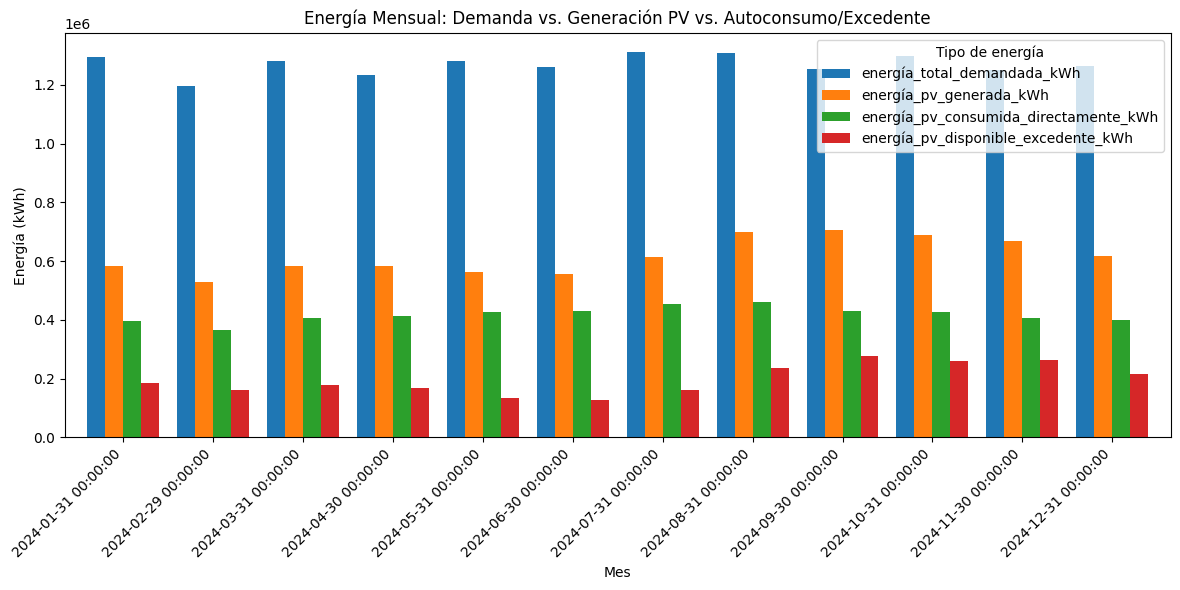

In [9]:
# ─── Celda 8: informe y visualización ─────────────────────────────────────────

# Generamos el informe mensual
report = monthly_report(df_metrics)
display(report)


# Y pintamos las barras
ax = plot_monthly(report)


In [10]:
from src.reporting       import plot_hourly_comparison
fig = plot_hourly_comparison(df_metrics)

In [12]:
fig.show() 